In [1]:
!pip install pyspellchecker
!pip install arabert
!pip install SpellChecker
!pip install transformers
!pip install -U symspellpy
!pip install -U accelerate
!pip install -U transformers
!pip install arabert
!pip install transformers
!pip install farasapy
!pip install pyarabic
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install pyarabic
!pip install arabic-reshaper
!pip install pyspellchecker
!pip install tqdm
!pip install aaransia
!pip install aaransia
!pip install pyspellchecker==0.5.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=7461856e6e378b7339b756c53d519204a17d3f6762af9c63a844545a35a284bb
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.8.0
    Uninstalling emoji-2.8.0:
      Successfully uninstalled emoji-2.8.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ | / done
  Preparing metadata (setup.py) ... - \ | / done
  Preparing metadata (setup.py) ... - \ 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
#from spellchecker import SpellChecker
from tqdm import tqdm
import re
import pyarabic.araby as araby
import pandas as pd
import numpy as np
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import pyarabic.araby as araby
import arabic_reshaper
from spellchecker import SpellChecker
from tqdm import tqdm
from aaransia import transliterate
from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, f1_score,recall_score)
from torch.utils.data import  Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                        AutoTokenizer, BertTokenizer, Trainer,
                        TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [5]:
path = "/kaggle/input/datasets-of-all/"
fields=['Tweet_ID','Tweets_withDecodedemojis','Final_Annotation']
train_dataset = pd.read_csv(path+'SaudiIrony.csv',usecols=fields)
train_Saudi= train_dataset['Tweets_withDecodedemojis']
train_d_pos = pd.DataFrame(train_Saudi, columns=[ 'Tweets_withDecodedemojis'])

train_d_pos.rename(columns = {'Tweets_withDecodedemojis':'tweet'}, inplace = True)
train_d_pos['dialect']='Saudi'
train_d_pos['tweet'] = train_d_pos['tweet'].astype(str)
train_d_pos

#tunisain
fields=['texts','data_labels']
train_dataset_tuii = pd.read_csv(path+ 'tun (2).csv',usecols=fields)
train_dataset_tu=train_dataset_tuii['texts']

train_t_pos = pd.DataFrame(train_dataset_tu, columns=[ 'texts'])
train_t_pos.rename(columns = {'texts':'tweet'}, inplace = True)
train_t_pos['dialect']='Tunisain'
#egypt
fields=['review']
train_dataset_eg = pd.read_csv(path+'40000-Egyptian-tweets.csv',usecols=fields)
train_d_eg=train_dataset_eg['review']

In [6]:
train_e_pos = pd.DataFrame(train_d_eg, columns=[ 'review'])
train_e_pos.rename(columns = {'review':'tweet'}, inplace = True)
train_e_pos['dialect']='Egyptian'
dataset= pd.concat([train_e_pos[1:6603],train_t_pos[1:6603]])
dataset= pd.concat([dataset, train_d_pos[1:6603]])

In [7]:
train_t_pos['dialect'].value_counts()
dataset=dataset.rename(columns={'dialect':'country','text':'tweet'})
dataset.to_csv("dataset.csv")

In [8]:
data = pd.read_csv(path+'dataset.csv')
print(data.shape)
data.head(2)
data  =  data[data['tweet'].isnull()==False]
data.head(2)

(19806, 3)


Unnamed: 0                                     tweet   country
0           1   دائما اكره اخر ليله في كل مكان           Egyptian
1           2  يارب اللى يسرق تويتاتى يدخل النار         Egyptian

In [9]:
from sklearn.model_selection import train_test_split
map_label={
    'Saudi':0,
    'Egyptian':1,
    'Tunisain':2,

}
label_map={
    0:'Saudi',
    1:'Egyptian',
    2:'Tunisain',

}


In [10]:
data =  data.rename(columns={'country':'dialect','tweet':'text'})
data['dialect'] = data['dialect'].map(map_label)

In [11]:
num_labels = 3
max_length = 30
max_length = 30
X = data['text']
y = data['dialect']
from sklearn.model_selection import train_test_split
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

In [12]:
train_data = pd.concat([X_train, y_train], axis=1, ignore_index=True)
test_data = pd.concat([X_test, y_test], axis=1, ignore_index=True)

# Rename the columns
train_data.columns = ['text', 'dialect']
test_data.columns = ['text', 'dialect']

In [13]:
test_data= test_data[test_data['dialect'].isnull()==False]
train_data = train_data[train_data['dialect'].isnull()==False]

In [14]:
train_data['dialect'] = train_data['dialect'].astype(int)
test_data['dialect'] = test_data['dialect'].astype(int)

In [15]:
!pip install PyArabic
!pip install  nltk

In [16]:
import tqdm
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocessing_V0_1_0(data):
    stop_words = set(stopwords.words('arabic'))

    for i in tqdm.tqdm(range(len(data))):
        # Get just Arabic text
        arabic_text = re.sub(r'[^ء-ي\s]', '', data['text'].iloc[i]).strip()

        # Remove duplicate letters
        arabic_text = re.sub(r'(.)\1+', r'\1', arabic_text).strip()

        # Tokenize using NLTK
        tweet_tokens = word_tokenize(arabic_text)

        # Remove stop words and single letters
        tweet = ' '.join(w for w in tweet_tokens if w not in stop_words and len(w) > 1)

        data['text'].iloc[i] = tweet

    return data

# Example usage:
# # Assuming you have a DataFrame called 'train_data' with a 'text' column
train_data_ = preprocessing_V0_1_0(train_data.copy())
test_data_ = preprocessing_V0_1_0(test_data.copy())


  0%|          | 0/15800 [00:00<?, ?it/s]/tmp/ipykernel_26/427784133.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'].iloc[i] = tweet
/tmp/ipykernel_26/427784133.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'].iloc[i] = tweet
/tmp/ipykernel_26/427784133.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'].iloc[i] = tweet
/tmp/ipykernel_26/427784133.py:23: SettingWithCopyWarning: 
A value 

In [17]:
train_data_.to_csv("train.csv")
test_data_.to_csv("test.csv")

# Check the availbility of GPU

In [18]:
import tensorflow as tf
print(len(tf.config.list_physical_devices('GPU')))
import torch
print(torch.cuda.is_available())

2
True


## Install gdown library

In [19]:
!pip install gdown

# Download datasets

In [20]:
!gdown --id 1SRB7w6x_6oVUOzJihlYA5T2VR8u0UJyd
!gdown --id 1zs91kg3MO6FNkmtHFo1bqOF2Iy1F1b4y
!gdown --id 165kzfZDsRTZAAfZKedeZiUlKzMcHNgPd

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SRB7w6x_6oVUOzJihlYA5T2VR8u0UJyd
To: /kaggle/working/Twitter_train.csv
100%|█████████████████████████████████████████| 261k/261k [00:00<00:00, 123MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zs91kg3MO6FNkmtHFo1bqOF2Iy1F1b4y
To: /kaggle/working/Twitter_test.csv
100%|███████████████████████████████████████| 84.4k/84.4k [00:00<00:00, 105MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't ne

In [21]:
!pip install pyarabic

In [22]:
import pyarabic.araby as ar

# import Stemmer
import functools, operator

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

## Load Dataset

In [23]:
import pandas as pd
df = pd.read_csv("train.csv")
seed=42

## Arabic stop words

In [24]:
arabic_stop_words=[]
with open ('./Arabic_stop_words.txt',encoding='utf-8') as f :
    for i in f.readlines() :
        arabic_stop_words.append(i)
        arabic_stop_words[-1]=arabic_stop_words[-1][:-1]


In [25]:
!pip install farasapy

In [26]:
import numpy as np
import pandas as pd
import re

#============= Read CSV and apply data preperation =============#


import re
from nltk.stem.isri import ISRIStemmer

def data_preprocessing(data_frame):
    # clean-up: remove #tags, http links, and special symbols
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: x[2:-2] if isinstance(x, str) else x)
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: re.sub(r'http\S+', '', str(x)) if isinstance(x, str) else x)
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: re.sub(r'[@|#]\S*', '', str(x)) if isinstance(x, str) else x)
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: re.sub(r'"+', '', str(x)) if isinstance(x, str) else x)

    # Remove arabic signs
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: re.sub(r'([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+', '', str(x)) if isinstance(x, str) else x)

    # Remove repeated letters like "الللللللللللللللله" to "الله"
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: x[0:2] + ''.join([x[i] for i in range(2, len(x)) if x[i] != x[i-1] or x[i] != x[i-2]]) if isinstance(x, str) else x)

    # remove stop words (make sure to define arabic_stop_words before using)
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: '' if x in arabic_stop_words else x if isinstance(x, str) else x)

    # Stemming using ISRIStemmer
    isri_stemmer = ISRIStemmer()
    data_frame['tweet'] = data_frame['tweet'].apply(lambda x: ' '.join([isri_stemmer.stem(word) for word in x.split()]) if isinstance(x, str) else x)

    return data_frame


In [27]:
!pip install emoji

In [28]:
import re
import string
import emoji
import functools
import operator

def data_cleaning(text):
    if isinstance(text, str):  # Check if text is a string
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"https\S+", "", text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub("(\s\d+)", "", text)
        text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
        text = re.sub("\d+", " ", text)
        text = text.replace("#", " ")
        text = text.replace("@", " ")
        text = text.replace("_", " ")
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)

        em = text
        em_split_emoji = emoji.get_emoji_regexp().split(em)
        em_split_whitespace = [substr.split() for substr in em_split_emoji]
        em_split = functools.reduce(operator.concat, em_split_whitespace)
        text = " ".join(em_split)
        text = re.sub(r'(.)\1+', r'\1', text)

        # Uncomment the following lines if you have a stemmer object (st)
        # text_stem = " ".join([st.stemWord(i) for i in text.split()])
        # text = text + " " + text_stem

        text = text.replace("آ", "ا")
        text = text.replace("إ", "ا")
        text = text.replace("أ", "ا")
        text = text.replace("ؤ", "و")
        text = text.replace("ئ", "ي")

    return text


In [29]:
df.columns = ["id" , 'tweet' , "dialect"]

In [30]:
df['tweet']=df['tweet'].apply(lambda x: data_cleaning(x))

In [31]:
df=data_preprocessing(df)
df

id                                              tweet  dialect
0       5771                                     جة قهر فقع مرا        1
1       6203                                     قط حكم رشد الك        1
2      10374                                                ستع        2
3       2557  هرد اليوم غرب صحت عشن مكج لقتش عند كحل ورح عشن...        1
4        380                                    يوم شاق جدا نهر        1
...      ...                                                ...      ...
15795  11285  دنا جزير جاو طير رنس زعم حبا بلد وفي ونس يطل ب...        2
15796  11965                                                ينا        2
15797   5391                       ب امك يخت ربن صبر علي قرف شا        1
15798    861                    ف برك عرس هرد جمل ليل هنولع علش        1
15799  15809           زلت نهق خلص نهى دور غير جحش برح طقطق علي        0

[15800 rows x 3 columns]

In [32]:
!git clone https://github.com/aub-mind/arabert.git

Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 31.63 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [33]:
from arabert.preprocess import ArabertPreprocessor

model_name = "aubmindlab/bert-large-arabertv02-twitter"
arabert_prep = ArabertPreprocessor(model_name=model_name)

df['tweet']=df['tweet'].apply(lambda x: arabert_prep.preprocess(x))


# text = "ولن نبالغ إذا قلنا: إن 'هاتف' أو 'كمبيوتر المكتب' في زمننا هذا ضروري"
# arabert_prep.preprocess(text)
# # "و+ لن نبالغ إذا قل +نا : إن ' هاتف ' أو ' كمبيوتر ال+ مكتب ' في زمن +نا هذا ضروري"

## Label Encoder

In [34]:
from sklearn import preprocessing
# Apply label encoding over the labels
lable_encoder = preprocessing.LabelEncoder()
encoded_labels =lable_encoder.fit_transform(df["dialect"])
df['dialect']=encoded_labels
df

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


id                                              tweet  dialect
0       5771                                     جة قهر فقع مرا        1
1       6203                                     قط حكم رشد الك        1
2      10374                                                ستع        2
3       2557  هرد اليوم غرب صحت عشن مكج لقتش عند كحل ورح عشن...        1
4        380                                    يوم شاق جدا نهر        1
...      ...                                                ...      ...
15795  11285  دنا جزير جاو طير رنس زعم حبا بلد وفي ونس يطل ب...        2
15796  11965                                                ينا        2
15797   5391                       ب امك يخت ربن صبر علي قرف شا        1
15798    861                    ف برك عرس هرد جمل ليل هنولع علش        1
15799  15809           زلت نهق خلص نهى دور غير جحش برح طقطق علي        0

[15800 rows x 3 columns]

In [35]:
df['length']=df['tweet'].apply(lambda x:len(x.split(' ')))
df['length'].max()

116

## Train Test Split

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation=train_test_split(df['tweet'], df['dialect'], test_size=0.2, random_state=seed)
X_validation

3964                            ل حرم سير ربي يعو وبء صبيح
291                                                    nan
3975     عرب كنت اضح وحد اله سمح كانت تقل تيب طقطق عليه...
12189                               ت علش تحلش خلل جمي عمد
1372                                    يخ اسك دخل رجل بحل
                               ...                        
8144                                 له عظم اني مو جلس اطق
10021                                  ظكم اله ورع وسد خطا
14807                  شاء اله وفق نجح تحا يكم جمع نتم لفر
8788                  شبب وبي قنص بدم برد حسبى اله نعم الك
12355                  وا حيل شوة عيز قفل شرع ده هرد علي خ
Name: tweet, Length: 3160, dtype: object

# Trying some machine learning models

## TF_IDF

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_ngram(n_gram,X_train,X_val):
    vectorizer = TfidfVectorizer(ngram_range=(n_gram,n_gram))
    x_train_vec = vectorizer.fit_transform(X_train)
    x_test_vec = vectorizer.transform(X_val)
    return x_train_vec,x_test_vec

In [38]:
# Applying tfidf with 1-gram, 2-gram and 3-gram
tfidf_1g_transformation_train,tfidf_1g_transformation_validation= tfidf_ngram(1,X_train,X_validation)
tfidf_2g_transformation_train,tfidf_2g_transformation_validation= tfidf_ngram(2,X_train,X_validation)

# Trying to use some pre-trained models from hugging face website 

## Install transformers

In [39]:
!pip install transformers

## Model and Tokenizer initialization

In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#============= Initialize Arabic Bert =============#
#load your pre_trained model with all its weights
# model_name= 'aubmindlab/bert-base-arabertv02'
model_name='UBC-NLP/MARBERT' #top
# model_name='asafaya/bert-base-arabic'
# model_name='AraBERTv0.2-Twitter-base'
# model_name='aubmindlab/bert-large-arabertv2'
# model_name='aubmindlab/bert-base-arabertv02-twitter'
# model_name='aubmindlab/bert-large-arabertv02-twitter'
# model_name='aubmindlab/aragpt2-base'

# model_name='aubmindlab/bert-base-arabertv2'
tokenizer =AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
# model=AutoModel.from_pretrained(model_name,output_hidden_states=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You can uncomment ay of the other models to get differnet accuraces

In [41]:
# Tokenize the sentences using bert tokenizer
df["bert_tokens"] = df.tweet.apply(lambda x: tokenizer(x).tokens())
df["bert_tokens_ids"] = df.tweet.apply(lambda x: tokenizer(x).tokens())
df["encoded"] = df.tweet.apply(lambda x: tokenizer.encode_plus(x,return_tensors='pt')['input_ids'])
df

id                                              tweet  dialect  \
0       5771                                     جة قهر فقع مرا        1   
1       6203                                     قط حكم رشد الك        1   
2      10374                                                ستع        2   
3       2557  هرد اليوم غرب صحت عشن مكج لقتش عند كحل ورح عشن...        1   
4        380                                    يوم شاق جدا نهر        1   
...      ...                                                ...      ...   
15795  11285  دنا جزير جاو طير رنس زعم حبا بلد وفي ونس يطل ب...        2   
15796  11965                                                ينا        2   
15797   5391                       ب امك يخت ربن صبر علي قرف شا        1   
15798    861                    ف برك عرس هرد جمل ليل هنولع علش        1   
15799  15809           زلت نهق خلص نهى دور غير جحش برح طقطق علي        0   

       length                                        bert_tokens  \
0           4              [[CLS], ج, ##ة, قهر, فقع, مرا, [SEP]]   
1           4                  [[CLS], قط, حكم, رشد, الك, [SEP]]   
2           1                                [[CLS], ستع, [SEP]]   
3          21  [[CLS], هرد, اليوم, غرب, صحت, عش, ##ن, مك, ##ج...   
4           4                 [[CLS], يوم, شاق, جدا, نهر, [SEP]]   
...       ...                                                ...   
15795      17  [[CLS], دنا, جزي, ##ر, جاو, طير, رن, ##س, زعم,...   
15796       1                                [[CLS], ينا, [SEP]]   
15797       8  [[CLS], ب, امك, يخت, رب, ##ن, صبر, علي, قرف, ش...   
15798       8  [[CLS], ف, برك, عرس, هرد, جمل, ليل, هن, ##ولع,...   
15799      10  [[CLS], زلت, نه, ##ق, خلص, نهى, دور, غير, جحش,...   

                                         bert_tokens_ids  \
0                  [[CLS], ج, ##ة, قهر, فقع, مرا, [SEP]]   
1                      [[CLS], قط, حكم, رشد, الك, [SEP]]   
2                                    [[CLS], ستع, [SEP]]   
3      [[CLS], هرد, اليوم, غرب, صحت, عش, ##ن, مك, ##ج...   
4                     [[CLS], يوم, شاق, جدا, نهر, [SEP]]   
...                                                  ...   
15795  [[CLS], دنا, جزي, ##ر, جاو, طير, رن, ##س, زعم,...   
15796                                [[CLS], ينا, [SEP]]   
15797  [[CLS], ب, امك, يخت, رب, ##ن, صبر, علي, قرف, ش...   
15798  [[CLS], ف, برك, عرس, هرد, جمل, ليل, هن, ##ولع,...   
15799  [[CLS], زلت, نه, ##ق, خلص, نهى, دور, غير, جحش,...   

                                                 encoded  
0      [[tensor(2), tensor(122), tensor(1046), tensor...  
1      [[tensor(2), tensor(3333), tensor(3577), tenso...  
2                [[tensor(2), tensor(31626), tensor(3)]]  
3      [[tensor(2), tensor(40005), tensor(2221), tens...  
4      [[tensor(2), tensor(2124), tensor(40320), tens...  
...                                                  ...  
15795  [[tensor(2), tensor(29470), tensor(14456), ten...  
15796             [[tensor(2), tensor(4183), tensor(3)]]  
15797  [[tensor(2), tensor(118), tensor(4952), tensor...  
15798  [[tensor(2), tensor(137), tensor(7093), tensor...  
15799  [[tensor(2), tensor(10427), tensor(5089), tens...  

[15800 rows x 7 columns]

In [42]:
!pip install keras_preprocessing

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


## Padding and attention mask

In [43]:
from keras_preprocessing.sequence import pad_sequences

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 64
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in df['bert_tokens']]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [44]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, encoded_labels,
                                                            random_state=seed, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=seed, test_size=0.1)
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)

## Set optimizer parameters

In [45]:
import torch.optim as optim

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]
# This variable contains all of the hyperparemeter information our training loop needs
# optimizer = optim.BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)
# optimizer = optim.AdamW(optimizer_grouped_parameters,lr=5e-6)
optimizer = optim.AdamW(optimizer_grouped_parameters,lr=.00001)

# Training

In [46]:
from tqdm import trange
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs
epochs = 11

# Transfer the model to GPU
model.to("cuda")

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    b_input_ids, b_input_mask, b_labels = batch
    b_labels = b_labels.type(torch.LongTensor)   # casting to long
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass
    loss = model(b_input_ids.to("cuda"), token_type_ids=None, attention_mask=b_input_mask.to("cuda"), labels=b_labels.to("cuda"))["loss"]
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()

    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_labels = b_labels.type(torch.LongTensor)   # casting to long
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids.to("cuda"), token_type_ids=None, attention_mask=b_input_mask.to("cuda"))

    # Move logits and labels to CPU
    logits = logits["logits"].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  if (eval_accuracy/nb_eval_steps) > 0.77 :
    break

Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 0.4885514351819128


Epoch:   0%|          | 0/11 [02:23<?, ?it/s]

Validation Accuracy: 0.8935227272727273


# Prepare testset with the same preprocessing

In [47]:
# df_submit = pd.read_csv("test.csv")
# df_submit

In [48]:
#============= Read CSV and apply data preperation =============#
df_submit = pd.read_csv("test.csv")
df_submit.columns = ['id' , 'tweet' , 'dialect']
test_labels = df_submit['dialect']
df_submit["tweet"] = df_submit.tweet.apply(lambda x: data_cleaning(x))
df_submit=data_preprocessing(df_submit)

df_submit['tweet']=df_submit['tweet'].apply(lambda x: arabert_prep.preprocess(x))

# Tokenize the sentences using bert tokenizer
df_submit["bert_tokens"] = df_submit.tweet.apply(lambda x: tokenizer(x).tokens())

In [49]:
bert_tokens_submit = df_submit["bert_tokens"]

In [50]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 129
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_submit = [tokenizer.convert_tokens_to_ids(x) for x in bert_tokens_submit]
# Pad our input tokens
input_ids_submit = pad_sequences(input_ids_submit, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks_submit = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_submit:
    seq_mask = [float(i>0) for i in seq]
    attention_masks_submit.append(seq_mask)


In [51]:
# Convert all of our data into torch tensors, the required datatype for our model
inputs_submit = torch.tensor(input_ids_submit)
masks_submit = torch.tensor(attention_masks_submit)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
batch_size = 64
submit_data = TensorDataset(inputs_submit, masks_submit)

# do not use shuffle, we need the preds to be in same order
submit_dataloader = DataLoader(submit_data, batch_size=batch_size)#, shuffle=True)
# Print the shape of inputs_submit and masks_submit
print("Shape of inputs_submit:", inputs_submit.size())
print("Shape of masks_submit:", masks_submit.size())

Shape of inputs_submit: torch.Size([3951, 129])
Shape of masks_submit: torch.Size([3951, 129])


In [52]:
# Put the model in an evaluation state
model.eval()

# Transfer model to GPU
model.to("cuda")

outputs = []
for input, masks in submit_dataloader:
    torch.cuda.empty_cache() # empty the gpu memory

    # Transfer the batch to gpu
    input = input.to('cuda')
    masks = masks.to('cuda')

    # Run inference on the batch
    output = model(input, attention_mask=masks)["logits"]

    # Transfer the output to CPU again and convert to numpy
    output = output.cpu().detach().numpy()

    # Store the output in a list
    outputs.append(output)

# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]
print(len(outputs))
# Inverse transform the label encoding
pred_flat = np.argmax(outputs, axis=1).flatten()
output_labels = lable_encoder.inverse_transform(pred_flat)

3951


In [53]:
print(len(output_labels))

3951


In [54]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
# Calculate accuracy
import math
accuracy = accuracy_score(test_labels, output_labels)
# accuracy = math.floor(accuracy)
# Format accuracy as a percentage with two decimal places
formatted_accuracy = "{:.2%}".format(accuracy)

print("Accuracy:", formatted_accuracy)
# print(f"Accuracy: {formatted_accuracy:.4f}")

Accuracy: 90.43%


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

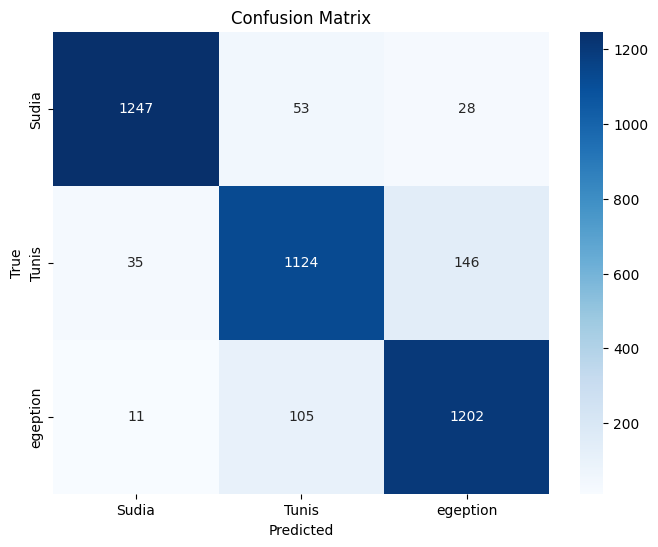

In [56]:
# Create a confusion matrix
conf_mat = confusion_matrix(test_labels, output_labels)
label_names = ['Sudia' , 'Tunis' , 'egeption']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [57]:
# Print classification report (includes precision, recall, and F1-score)
class_report = classification_report(test_labels, output_labels, target_names=label_names)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

       Sudia       0.96      0.94      0.95      1328
       Tunis       0.88      0.86      0.87      1305
    egeption       0.87      0.91      0.89      1318

    accuracy                           0.90      3951
   macro avg       0.90      0.90      0.90      3951
weighted avg       0.91      0.90      0.90      3951



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [58]:
# submission = pd.DataFrame({"Id":np.arange(1, len(output_labels)+1), "class":output_labels})
# # save (submission)
# submission.to_csv("submission.csv", index=False)